# Challenge 3
## Natural Language Processing
### Feeling analysis on Amazon 

In [177]:
import pandas as pd
import matplotlib.pyplot as plt
from math import *
from wordcloud import WordCloud
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# nltk.download('stopwords')
# nltk.download('punkt')

1) Initial data exploration

In [178]:
reviews = pd.read_csv("amazon_alexa.csv")
reviews_original = reviews.copy(deep=True)  # Clean copy of the dataset, just in case...

In [179]:
reviews_original

,rating,date,variation,verified_reviews
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!
1,5,31-Jul-18,Charcoal Fabric,Loved it!
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer..."
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...
4,5,31-Jul-18,Charcoal Fabric,Music
...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe..."
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check..."
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my..."
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...


a) Existence of empty data.

In [180]:
reviews.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
dtype: int64

In [181]:
# Replace NaN with an empty string to avoid issues in future usage
reviews["verified_reviews"] = reviews["verified_reviews"].fillna("")

b) Customer ratings (*rating* column).

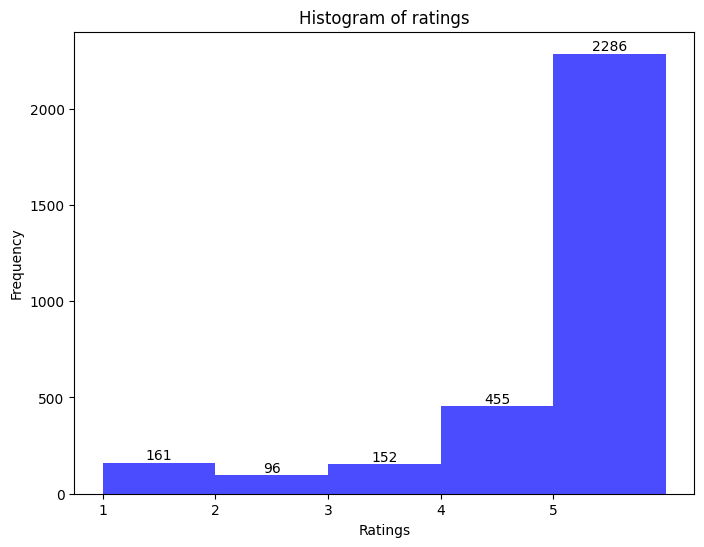

In [182]:
# Define the range and step for the bins
min_rating = reviews['rating'].min()
max_rating = reviews['rating'].max()
bins = range(min_rating, max_rating + 2, 1)  # +2 to include the last edge

# Create the histogram
plt.figure(figsize=(8, 6))
n, bins, patches = plt.hist(reviews['rating'], bins=bins, color='blue', alpha=0.7)

# Add numbers above each bar
for rect, count in zip(patches, n):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2., height, f'{int(count)}', ha='center', va='bottom')

plt.title('Histogram of ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')

# Set x-axis ticks
plt.xticks(range(min_rating, max_rating + 1, 1))

plt.show()

c) The length (number of words) of the opinions.

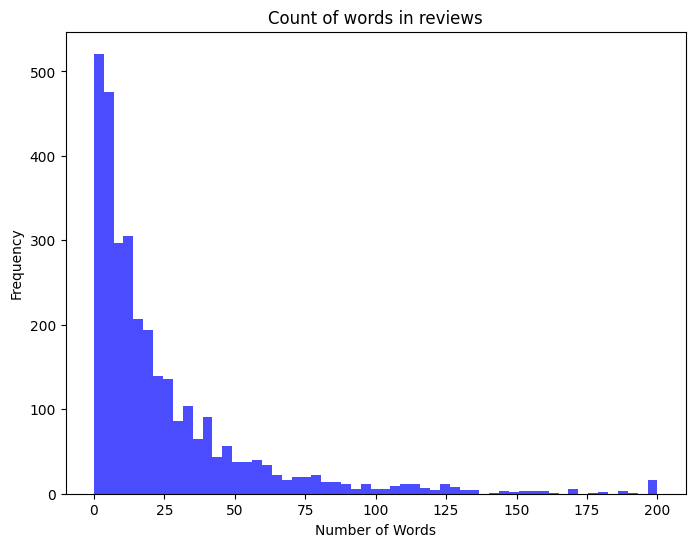

In [183]:
# Function to count words in a sentence
def word_count(sentence):
    return len(sentence.split())


# Apply the function to the 'sentence' column
reviews['word_count'] = reviews['verified_reviews'].apply(word_count)
reviews['word_count'] = reviews['word_count'].clip(upper=200)

# Create the histogram
plt.figure(figsize=(8, 6))
n, bins, patches = plt.hist(reviews['word_count'], bins='auto', color='blue', alpha=0.7)

plt.title('Count of words in reviews')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.show()

d) A couple of opinions whose length is around the numerical average of words, taking as a reference the corpus of opinions

In [184]:
word_count_mean = floor(reviews['word_count'].mean())
average_length_reviews = reviews[reviews['word_count'] == word_count_mean]
sample = average_length_reviews.sample(2)

print("Sample of opinions with an average length:")
print(f"Opinion 1: {sample.iloc[0]['verified_reviews']}")
print(f"Opinion 2: {sample.iloc[1]['verified_reviews']}")

Sample of opinions with an average length:
Opinion 1: We love having this in our kitchen! Very convenient to look up recipes, listen to the news, or watch prime video while I'm cooking
Opinion 2: So far it has worked well. Not always intuitive as to how to link different devices, or "skills", but getting the hang of it.


e) Words with the greatest presence in the corpus of opinions.

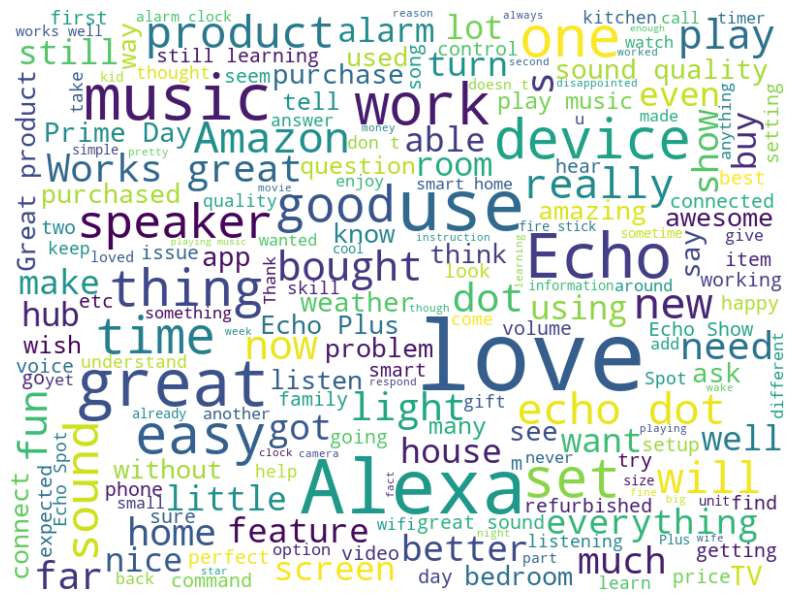

In [185]:
corpus = " ".join(sentence for sentence in reviews['verified_reviews'])

wordcloud = WordCloud(
    background_color='white',
    width=800,
    height=600,
    max_font_size=100
).generate(corpus)

# Display the generated WordCloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

2) Text preprocessing

In this phase it is necessary to preprocess the text with the opinions as previous step to the construction of the model. To do so, code a function to delete both punctuation marks and irrelevant words, so then it can be applied to the corresponding Pandas column. 

In [186]:
def remove_punctuation(sentence):
    return ''.join(char for char in sentence if char not in string.punctuation)

In [187]:
def remove_stop_words(sentence):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(sentence)
    filtered_sentence = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_sentence)

In [188]:
def clean_sentence(sentence):
    return remove_stop_words(remove_punctuation(sentence))

In [189]:
reviews["verified_reviews"] = reviews["verified_reviews"].apply(clean_sentence)

In [190]:
reviews

,rating,date,variation,verified_reviews,word_count
0,5,31-Jul-18,Charcoal Fabric,Love Echo,3
1,5,31-Jul-18,Charcoal Fabric,Loved,2
2,4,31-Jul-18,Walnut Finish,Sometimes playing game answer question correct...,38
3,5,31-Jul-18,Charcoal Fabric,lot fun thing 4 yr old learns dinosaurs contro...,34
4,5,31-Jul-18,Charcoal Fabric,Music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,Perfect kids adults everyone,8
3146,5,30-Jul-18,Black Dot,Listening music searching locations checking t...,23
3147,5,30-Jul-18,Black Dot,love things running entire home TV lights ther...,83
3148,5,30-Jul-18,White Dot,complaint sound quality isnt great mostly use ...,76


3) previous step to model preparation

Add a column named "feedback" with values 1 (which means having a positive opinion) and 0 (which means having a negative opinion) from the ratings given by te Amazon clients. For this purpose, in order to reduce the score to only two cases (classes) we will consider as "1" those customer opinions that have scored 3 or more, and "0" to those that have been lower than 3.

In [191]:
def get_feedback(rating):
    if rating >= 3:
        return 1
    return 0

In [192]:
reviews['feedback'] = reviews['rating'].apply(get_feedback)

4) Creation and analysis of result of a Naive Bayes model

In [193]:
# Dividimos los datos en dos partes: entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(reviews['verified_reviews'], reviews['feedback'], random_state=2055)

In [194]:
count_vector = CountVectorizer(stop_words='english')

training_data = count_vector.fit_transform(X_train)
testing_data = count_vector.transform(X_test)

In [195]:
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

MultinomialNB()

In [196]:
predictions = naive_bayes.predict(testing_data)

In [197]:
print('Accuracy score: ', format(accuracy_score(y_test, predictions)))
print('Precision score: ', format(precision_score(y_test, predictions)))
print('Recall score: ', format(recall_score(y_test, predictions)))
print('F1 score: ', format(f1_score(y_test, predictions)))

Accuracy score:  0.9124365482233503
Precision score:  0.918075422626788
Recall score:  0.9915730337078652
F1 score:  0.9534098582039163


a) Resulting confusion matrix

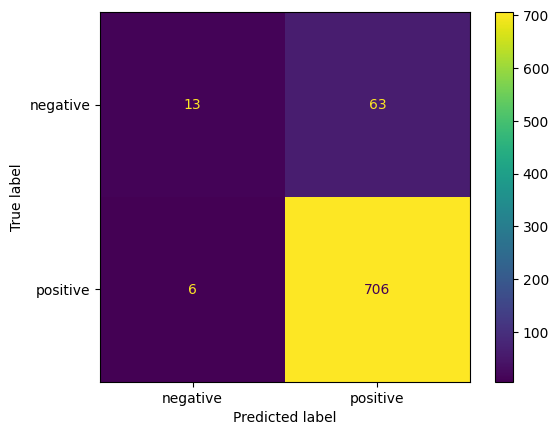

In [198]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'positive'])

disp.plot()
plt.show()

b) Metrics report

In [199]:
print(classification_report(y_test, predictions, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.68      0.17      0.27        76
    positive       0.92      0.99      0.95       712

    accuracy                           0.91       788
   macro avg       0.80      0.58      0.61       788
weighted avg       0.90      0.91      0.89       788


1. What can we say about the reliability of the mode's prediction?

After analyzing the confusion matrix and the metrics, there is a big difference on the models performance depending on the target, which affects considerable its overall reliability. The model is fairly accurate when predicting positive reviews. However, due to the lack of negative samples, the model performs poorly when predicting a negative review. This model could definitely be useful in certain cases such as a filtering review comments in order to have a quick first impression of the product. But, since the model is pretty biased towards positive opinions it would be unfair to make important decisions on a product by just using the model itself.

2. What similarities and differences share the approach, development and resolutions of this case using Naïve Bayes compared to the two cases discussed in class (Spam analysis practice, in one hand, and identifying an anonymous sender of a letter, on the other)?

- A difference between these problems is that both the Amazon reviews and the spam detector are binary classification problems and the anonymous sender is a multiclass identification problem 
- A difference between these problems is that in the Amazon reviews there was no explicit target, and in order to obtain a target that could fit the problem description, it was needed to calculate it from another column. This was not an issues on the other problems because the target to predict was given.